# Multi-Strain SIR Model

This implements a simple multi-strain SIR model where there is cross immunity between strains defined by a matrix.

In [1]:
import sys
sys.path.append('../')
#sys.path.append('../tabluarepimdl')
import tabularepimdl as tepi

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

## Defining a Population

This is just like a one strain model, but with placeholders for three strains. 

In [2]:
## Population
pop_3strain = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S'], categories=['S','I','R']),
        "Strain3": pd.Categorical(['S','S'], categories=['S','I','R']),
        "N": np.array([990,10]),
        "T":0
    }
)


## Defining the Cross Protection Matrix and Infection Rule

We now define immunity such tht "adjacent" strains have 50% cross protection and "non-adjacent" strains have 20% cross protection. That is, cross immunity is defined by this matrix:

$$
\begin{bmatrix}
1&.5&.2\\
.5&1&.5\\
.2&.5&1
\end{bmatrix}
$$




In [3]:
##Cross protection matrix.
cp_matrix = np.array([[1.0, 0.5, 0.2],
                      [0.5, 1.0, 0.5],
                      [0.2, 0.5, 1.0]])

Use the cross-protection matrix to construct an infection rule. Assuming all strains have the same infecitous period (5 days), we are going to set this up so the strains are progressively more infectious, with $R_0$ progressing from 2.5 to 5.

In [4]:
three_strain_infect = tepi.MultiStrainInfectiousProcess(
    betas=np.array([0.5, 0.75, 1]),
    columns=["Strain1", "Strain2", "Strain3"],
    cross_protect=cp_matrix)

## Creating and Running a Deterministic Epidemic Model

Put above rules all together in a deterministic epidemic model, 
specifying the recovery times.

In [5]:
SIR_3Strain = tepi.EpiModel(pop_3strain, rules = [
    three_strain_infect,
    tepi.SimpleTransition('Strain1','I','R', 0.2),
    tepi.SimpleTransition('Strain2','I','R', 0.2),
    tepi.SimpleTransition('Strain3','I','R', 0.2)
])

Run the model. In the loop we can introduce an infected person with the appropriate characteristics on the appropriate days. In this case
day 11 and day 20.

In [6]:
intro_day1 = 11
intro_day2 = 20

for t in np.arange(0,100,0.25):
    if t == intro_day1:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['I'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['S'], categories=['S','I','R']),
            'N':1,
            'T':[t]
         })
        SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
    if t == intro_day2:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['I'], categories=['S','I','R']),
            'N':1,
            'T':[t]
         })
        SIR_3Strain.cur_state = pd.concat([SIR_3Strain.cur_state, to_add])
    SIR_3Strain.do_timestep(dt=0.25)

Plot the graph.

In [7]:
long_epi_determ = SIR_3Strain.full_epi.melt(id_vars=['N','T'], value_vars=['Strain1', 'Strain2', 'Strain3'], var_name='Strain', value_name="InfState")
long_epi_determ = long_epi_determ.groupby(["T","Strain","InfState"]).sum().reset_index()

epi_fig_determ = px.line(long_epi_determ, x="T", y="N", color="InfState", line_dash="Strain", title='3 Strains Infection Change on a Population - Deterministic')
epi_fig_determ.show()


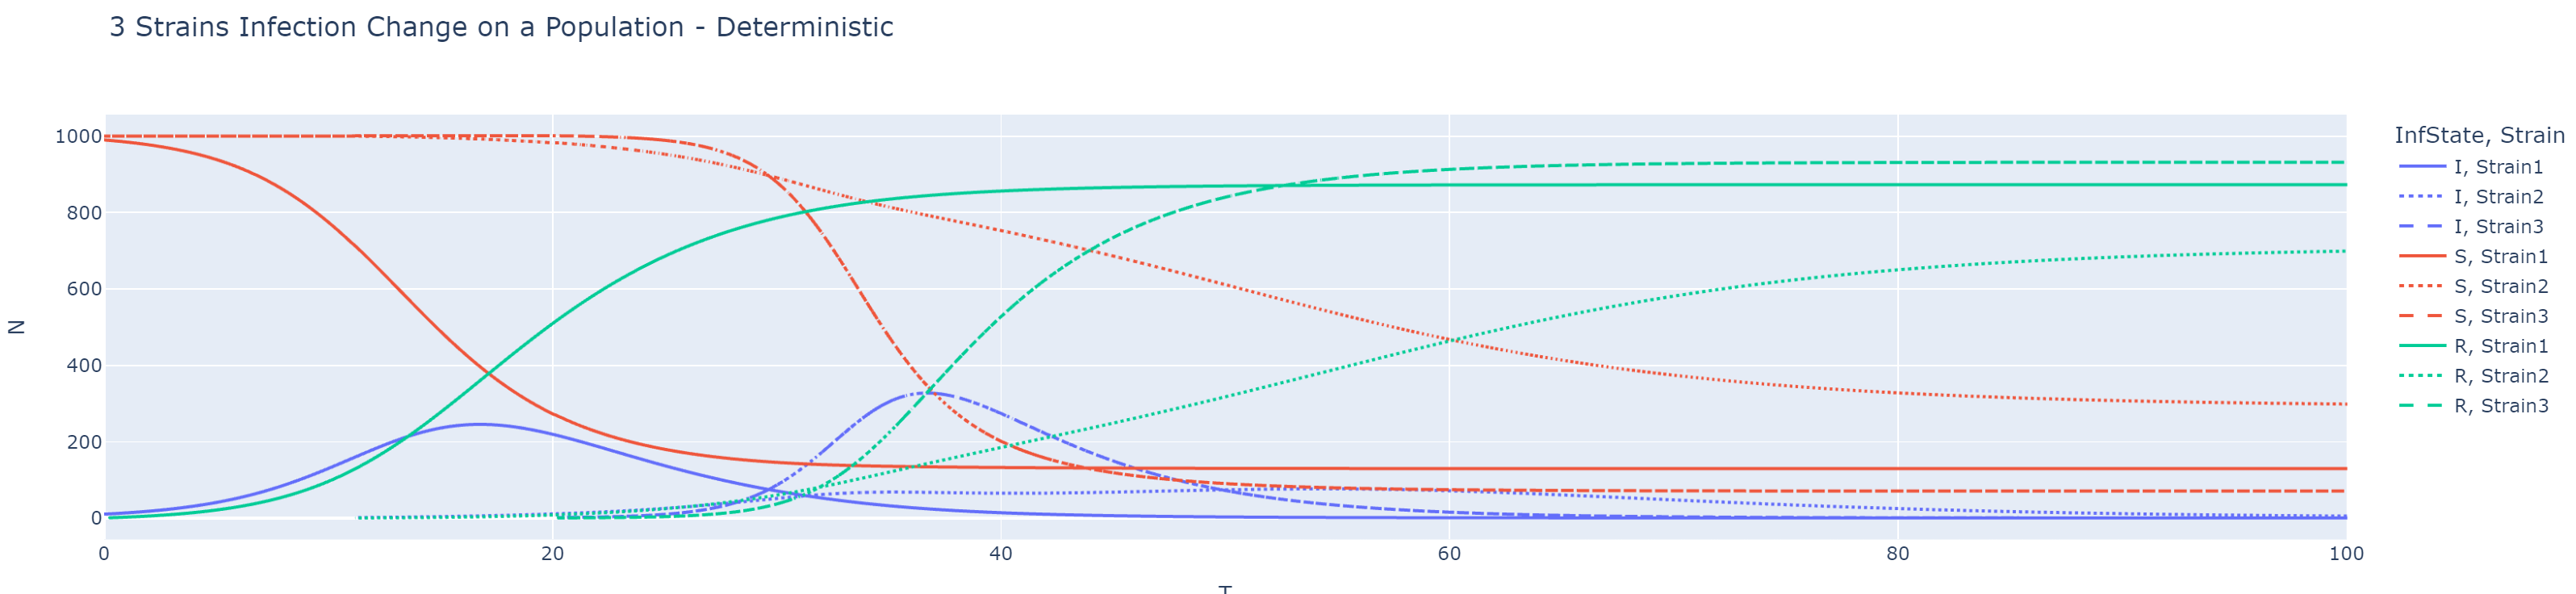

### Add Stochastic Simple Observation Rule

In [8]:
pop_3strain_hosp = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I','R'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S','I'], categories=['S','I','R']),
        "Strain3": pd.Categorical(['I','S','S'], categories=['S','I','R']),
        "Hosp1": "U",
        "Hosp2": "U",
        "Hosp3": "U",
        "N": np.array([1000,1000,1000]),
        "T":0
    }
)
pop_3strain_hosp

,Strain1,Strain2,Strain3,Hosp1,Hosp2,Hosp3,N,T
0,S,S,I,U,U,U,1000,0
1,I,S,S,U,U,U,1000,0
2,R,I,S,U,U,U,1000,0


In [9]:
hosp_rule1 = tepi.SimpleObservationProcess(source_col="Strain1",source_state="I", obs_col="Hosp1", rate=.05, stochastic=True)
hosp_rule2 = tepi.SimpleObservationProcess(source_col="Strain2",source_state="I", obs_col="Hosp2", rate=.02, stochastic=True)
hosp_rule3 = tepi.SimpleObservationProcess(source_col="Strain3",source_state="I", obs_col="Hosp3", rate=.01, stochastic=True)

In [10]:
#test the rule
print(hosp_rule1.get_deltas(pop_3strain_hosp))
print(hosp_rule2.get_deltas(pop_3strain_hosp))
print(hosp_rule3.get_deltas(pop_3strain_hosp))

  Strain1 Strain2 Strain3 Hosp1 Hosp2 Hosp3   N  T
0       I       S       S     U     U     U -57  0
1       I       S       S     I     U     U  57  0
  Strain1 Strain2 Strain3 Hosp1 Hosp2 Hosp3   N  T
0       R       I       S     U     U     U -24  0
1       R       I       S     U     I     U  24  0
  Strain1 Strain2 Strain3 Hosp1 Hosp2 Hosp3   N  T
0       S       S       I     U     U     U -14  0
1       S       S       I     U     U     I  14  0


Add Simple Observation rule to the epidemic model. Note that this rule need to be in a different rule group so there is not "competition" for people from various states.


In [11]:
#Create the base population, this time with only one person infected with strain 1.

pop_3strain_hosp = pd.DataFrame(
    {
        "Strain1": pd.Categorical(['S','I'], categories=['S','I','R']),
        "Strain2": pd.Categorical(['S','S'], categories=['S','I','R']),
        "Strain3": pd.Categorical(['S','S'], categories=['S','I','R']),
        "Hosp1": "U",
        "Hosp2": "U",
        "Hosp3": "U",
        "N": np.array([9999,1]),
        "T":0
    }
)


# Make the epidemic model
SIR_3Strain_hosp =  tepi.EpiModel(pop_3strain_hosp, rules = [[
    three_strain_infect,
    tepi.SimpleTransition('Strain1','I','R', 0.1),
    tepi.SimpleTransition('Strain2','I','R', 0.05),
    tepi.SimpleTransition('Strain3','I','R', 0.2)],
    [hosp_rule1, hosp_rule2, hosp_rule3]
])


#Run the model
intro_day1 = 11
intro_day2 = 20

for t in np.arange(0,100,0.25):
    
    if t == intro_day1:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['I'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['S'], categories=['S','I','R']),
            'Hosp1': ['U'],
            'Hosp2': ['U'],
            'Hosp3': ['U'],
            'N':1,
            'T':[t]
         })
        SIR_3Strain_hosp.cur_state = pd.concat([SIR_3Strain_hosp.cur_state, to_add])
    if t == intro_day2:
        to_add = pd.DataFrame({
            'Strain1':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain2':pd.Categorical(['S'], categories=['S','I','R']),
            'Strain3':pd.Categorical(['I'], categories=['S','I','R']),
            'Hosp1': ['U'],
            'Hosp2': ['U'],
            'Hosp3': ['U'],
            'N':1,
            'T':[t]
         })
        SIR_3Strain_hosp.cur_state = pd.concat([SIR_3Strain_hosp.cur_state, to_add])
    SIR_3Strain_hosp.do_timestep(dt=0.25)

In [12]:
SIR_3Strain_hosp.cur_state

,Strain1,Strain2,Strain3,Hosp1,Hosp2,Hosp3,N,T
4,I,R,R,P,P,U,0.865448,100.0
5,I,R,R,P,U,U,3.467183,100.0
6,I,R,R,U,P,P,0.141692,100.0
7,I,R,R,U,P,U,2.802494,100.0
8,I,R,R,U,U,P,0.252295,100.0
...,...,...,...,...,...,...,...,...
96,S,R,S,U,P,U,147.249740,100.0
97,S,R,S,U,U,U,208.057425,100.0
99,S,S,I,U,U,U,0.000017,100.0
100,S,S,R,U,U,U,0.031003,100.0


In [13]:
long_epi_determ_obs_stoch = SIR_3Strain_hosp.full_epi.melt(id_vars=['N','T'], value_vars=['Strain1', 'Strain2', 'Strain3'], var_name='Strain', value_name="InfState")
long_epi_determ_obs_stoch = long_epi_determ_obs_stoch.groupby(["T","Strain","InfState"]).sum().reset_index()

epi_fig_determ_obs_stoch = px.line(long_epi_determ_obs_stoch, x="T", y="N", color="InfState", line_dash="Strain", title='3 Strains Infection Change on a Population - Deterministic with Stochastic Observation')
epi_fig_determ_obs_stoch.show()

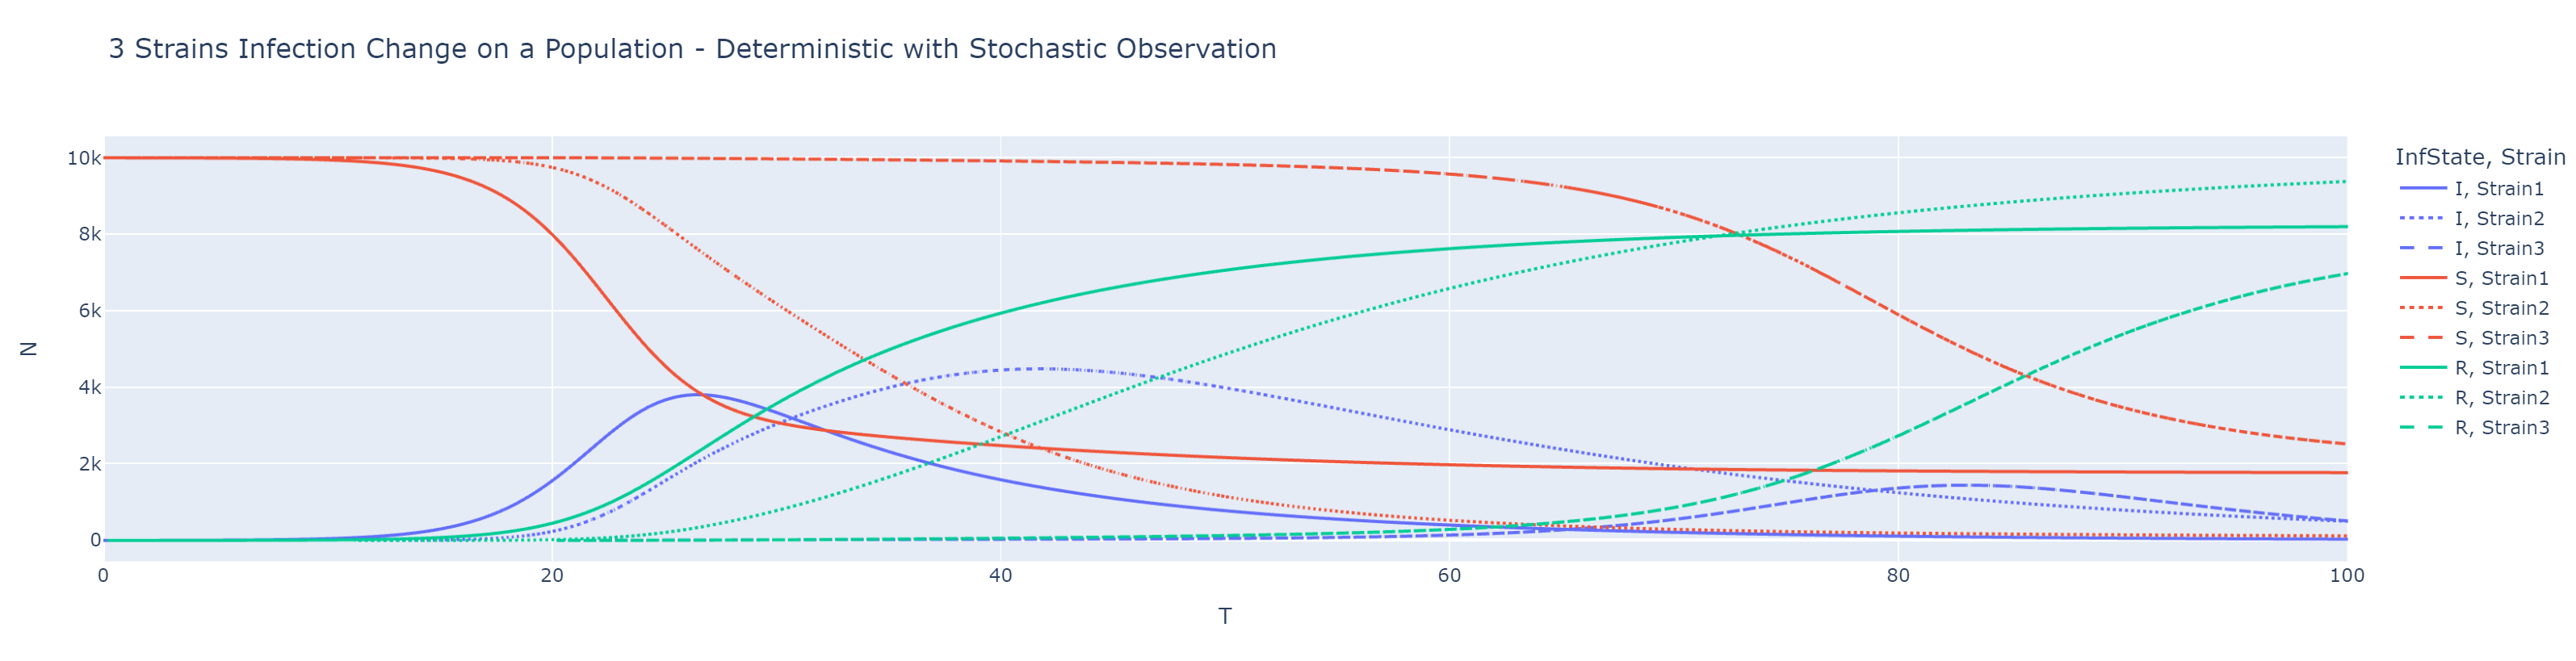

In [14]:
long_epi_determ_obs_stoch_hosp = SIR_3Strain_hosp.full_epi.melt(id_vars=['N','T'], value_vars=['Hosp1', 'Hosp2', 'Hosp3'], var_name='Hosp', value_name="HospState")
long_epi_determ_obs_stoch_hosp = long_epi_determ_obs_stoch_hosp.groupby(["T","Hosp","HospState"]).sum().reset_index()

epi_fig_determ_obs_stoch_hosp = px.line(long_epi_determ_obs_stoch_hosp, x="T", y="N", color="HospState", line_dash="Hosp", title='Hospitality Change on a Population - Deterministic with Stochastic Observation')
epi_fig_determ_obs_stoch_hosp.show()

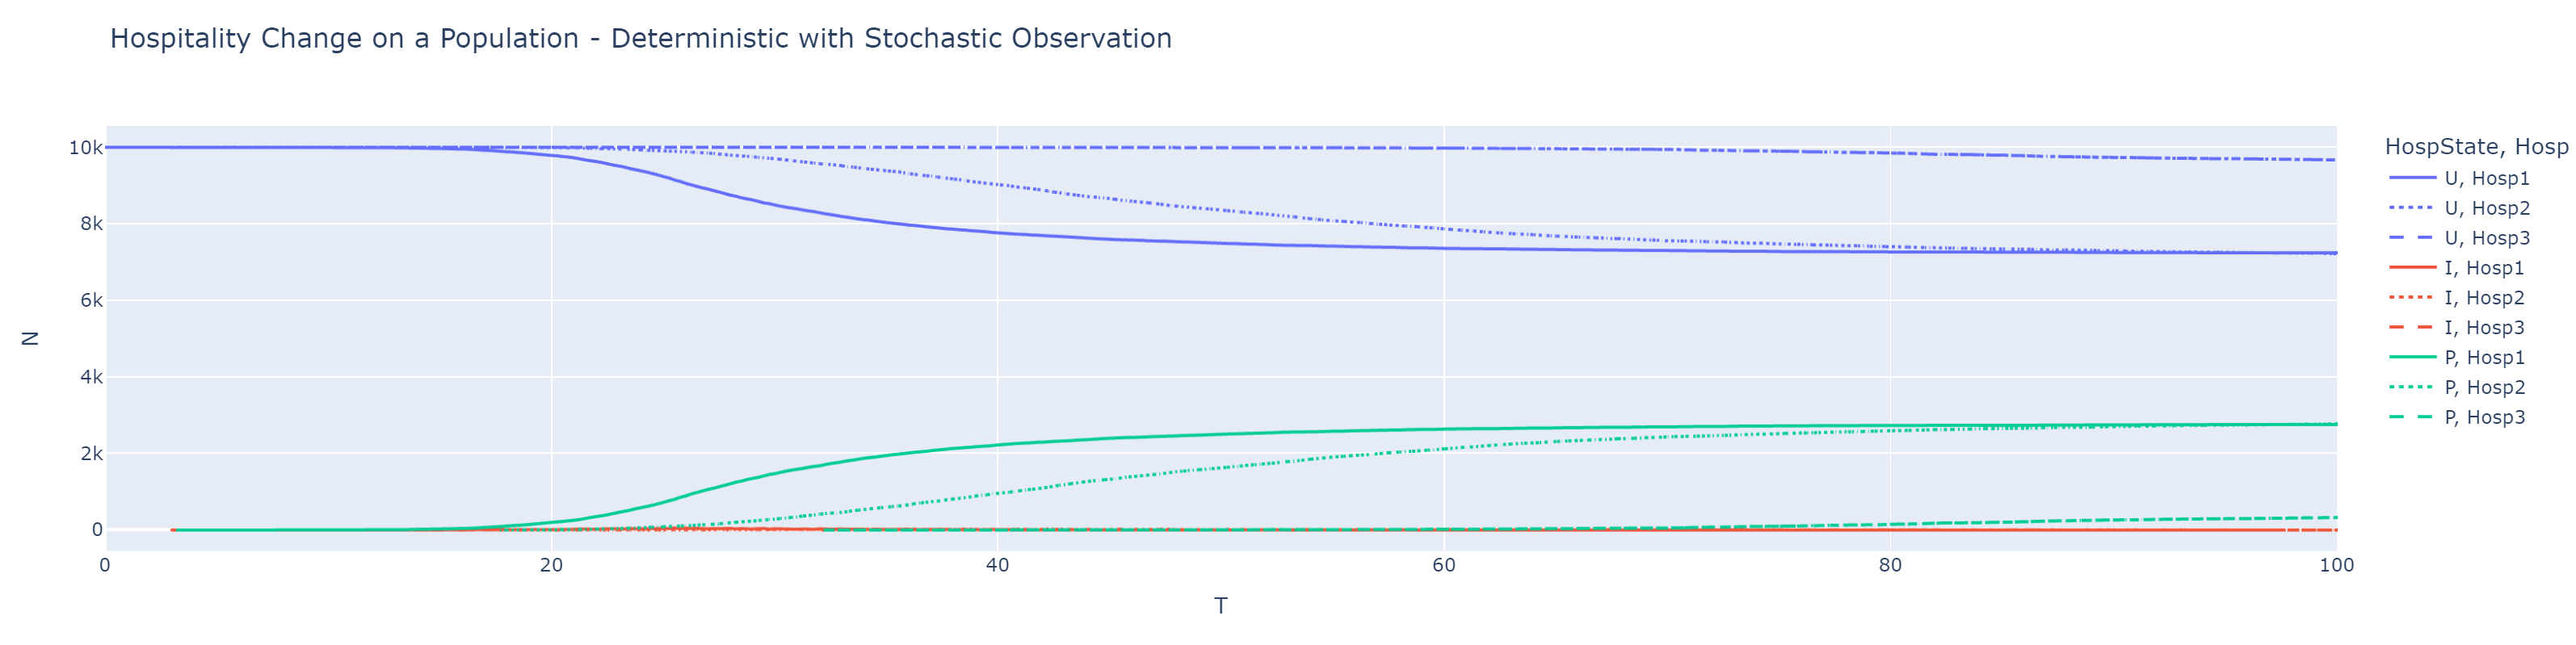